# Introducción a la Ciencia de Datos: Tarea 2

Este notebook contiene el código de base para realizar la Tarea 2 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/).

**Se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.


## Cargar bibliotecas (dependencias)
Recuerde instalar los requerimientos (`requirements.txt`) en el mismo entorno donde está ejecutando este notebook (ver [README](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/)). Para la entrega 2 hay nuevas dependencias, por lo que es importante correr la siguiente celda.

In [2]:
import re
import os

from time import time
from pathlib import Path
import contractions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
import nltk
import matplotlib.patches as mpatches


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Lectura de Datos

In [3]:
# DataFrame con todos los discursos:
url = "https://raw.githubusercontent.com/SantiQuinteros/Curso-Ciencia-Datos-FING/refs/heads/main/Datos/us_2020_election_speeches.csv"
df = pd.read_csv(url)

In [4]:
# Seperar speakers combinados 

df = df.assign(speaker=df['speaker'].str.split(',')).explode('speaker').reset_index(drop=True)

In [5]:
# Quedarse con 5 candidatos con más discursos

conteo = df['speaker'].value_counts()

top_5_speaker = conteo.head(5).index.tolist()

df_speeches_top_5 = df[df['speaker'].isin(top_5_speaker)]


In [6]:
df_speeches_top_5['speaker'].unique()

array(['Joe Biden', 'Donald Trump', 'Mike Pence', 'Kamala Harris',
       'Bernie Sanders'], dtype=object)

In [7]:
# Limpieza del nombre del candidato en los textos

df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('President Trump', "Donald Trump")
df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('President Donald J. Trump', "Donald Trump")
df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('Donald J. Trump', "Donald Trump")
df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('Senator Harris', "Kamala Harris")
df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('Vice President Mike Pence ', "Mike Pence")
df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('Vice President Biden', "Joe Biden")

C:\Users\santi\AppData\Local\Temp\ipykernel_19508\1090779935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('President Trump', "Donald Trump")
C:\Users\santi\AppData\Local\Temp\ipykernel_19508\1090779935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('President Donald J. Trump', "Donald Trump")
C:\Users\santi\AppData\Local\Temp\ipykernel_19508\1090779935.py:5: Setting

In [8]:
# Funcion para quedarnos solamente con los discursos del speaker en cuestion

def extract_speaker_phrases(text, speaker):
    
    speaker_escaped = re.escape(speaker)
    
    pattern = rf'({speaker_escaped}:.*?\n.*?\n)'
    matches = re.findall(pattern, text, re.DOTALL)
    return [m.strip() for m in matches]

In [9]:
df_speeches_top_5['Phrases'] = df_speeches_top_5.apply(lambda row: extract_speaker_phrases(row['text'], row['speaker']), axis=1)

C:\Users\santi\AppData\Local\Temp\ipykernel_19508\3425570893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['Phrases'] = df_speeches_top_5.apply(lambda row: extract_speaker_phrases(row['text'], row['speaker']), axis=1)


In [10]:
# Funcion para quitar del discurso el nombre del speaker y los minutos, dado que no forman parte de las palabras que dijo

def clean_phrase(phrase, speaker):
   
    speaker_pattern = rf'{re.escape(speaker)}:\s*\(\d{{2}}:\d{{2}}\)\s*\n'
    cleaned = re.sub(speaker_pattern, '', phrase)
    return cleaned.strip()

In [11]:
df_speeches_top_5['Phrases_2'] = df_speeches_top_5.apply(
    lambda row: [clean_phrase(p, row['speaker']) for p in row['Phrases']],
    axis=1
)

C:\Users\santi\AppData\Local\Temp\ipykernel_19508\3354532343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['Phrases_2'] = df_speeches_top_5.apply(


In [12]:
#Funcion para limpiar textos y normalizar palabras

def clean_text(df, column_name):
    def clean_phrase_list(phrases):
        if not isinstance(phrases, list):
            return phrases
        cleaned = []
        for phrase in phrases:

            phrase = str(phrase).lower()
            for punc in ["\n", ",", ":", "?", ".", "(", ")", "1","2","3","4","5","6","7","8","9","0","...","“","”", "…", ",", ",", "[", "]",  "!",";"]:
                phrase = phrase.replace(punc, " ")
            cleaned.append(phrase.strip())
        return cleaned

    return df[column_name].apply(clean_phrase_list)

In [13]:
df_speeches_top_5['Phrases_3'] = clean_text(df_speeches_top_5, 'Phrases_2')

C:\Users\santi\AppData\Local\Temp\ipykernel_19508\3497878664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['Phrases_3'] = clean_text(df_speeches_top_5, 'Phrases_2')


In [14]:
# Aplicar funcion para modificar palabras abreviadas

df_speeches_top_5['speech'] = df_speeches_top_5['Phrases_3'].apply(
    lambda x: contractions.fix(" ".join(x)) if isinstance(x, list) else contractions.fix(str(x))
)

df_speeches_top_5['speech_2'] = df_speeches_top_5['Phrases_2'].apply(
    lambda x: contractions.fix(" ".join(x)) if isinstance(x, list) else contractions.fix(str(x))
)

C:\Users\santi\AppData\Local\Temp\ipykernel_19508\3750449655.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['speech'] = df_speeches_top_5['Phrases_3'].apply(
C:\Users\santi\AppData\Local\Temp\ipykernel_19508\3750449655.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['speech_2'] = df_speeches_top_5['Phrases_2'].apply(


## Parte 1: Dataset y representación numérica de texto

In [15]:
#Data frame final

conteo = df_speeches_top_5['speaker'].value_counts()

df = df_speeches_top_5[df_speeches_top_5['speaker'].isin(conteo.head(3).index.tolist())][['speaker', 'speech', 'speech_2' ]]

In [16]:
# Separar base en dev y test

X = df['speech']
y = df['speaker'] 

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Tamaños de los conjuntos: {X_dev.shape}, {X_test.shape}")

Tamaños de los conjuntos: (107,), (46,)


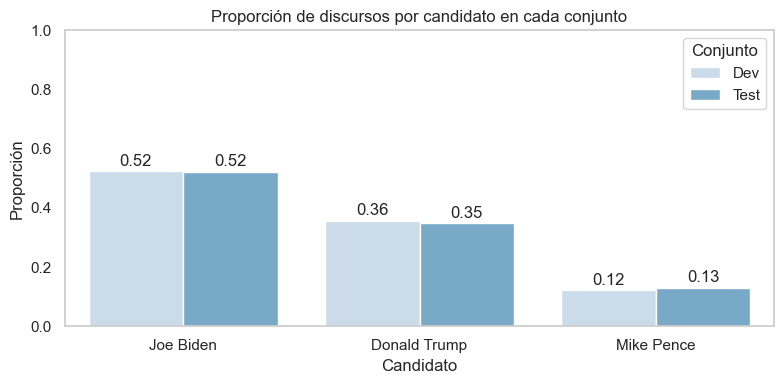

In [17]:
# 2: Visualización de la proporción de cada candidato por conjunto
proporcion_dev = y_dev.value_counts(normalize=True)
proporcion_test = y_test.value_counts(normalize=True)

df_proporciones = pd.DataFrame({
    'Dev': proporcion_dev,
    'Test': proporcion_test
}).fillna(0)

df_proporciones.reset_index(inplace=True)  
df_proporciones.columns.name = None 

id_col = df_proporciones.columns[0]

df_long = df_proporciones.melt(id_vars=id_col, var_name='Conjunto', value_name='Proporción')
df_long.rename(columns={id_col: 'Candidato'}, inplace=True)

orden_candidatos = df['speaker'].value_counts().index

sns.set(style="whitegrid")
palette = sns.color_palette("Blues", n_colors=df_long['Candidato'].nunique())

plt.figure(figsize=(8, 4))
ax = sns.barplot(
    data=df_long,
    x='Candidato',
    y='Proporción',
    hue='Conjunto',
    order=orden_candidatos,
    palette=palette
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=2)

plt.title("Proporción de discursos por candidato en cada conjunto")
plt.ylim(0, 1)
plt.ylabel("Proporción")
plt.xlabel("Candidato")
plt.legend(title="Conjunto")
plt.grid(False)
plt.tight_layout()
plt.show()


In [18]:
# 3: Transformar el texto del conjunto de entrenamiento a la representación numérica (features) de conteo de palabras o bag of words.

vectorizer = CountVectorizer()

X_dev_bow = vectorizer.fit_transform(X_dev)

X_test_bow = vectorizer.transform(X_test)


In [19]:
print(f"Shape X_dev_bow: {X_dev_bow.shape}")   # (n_muestras_dev, n_palabras_unicas)
print(f"Shape X_test_bow: {X_test_bow.shape}") # (n_muestras_test, n_palabras_unicas)

Shape X_dev_bow: (107, 11620)
Shape X_test_bow: (46, 11620)


La matriz de dev se compone de 107 discursos, los cueles tienen 11620 palabras unicas.

¿Qué es Bag of Words?

Bag of Words (BoW) es una técnica de representación de texto que convierte documentos (como discursos) en vectores numéricos. No considera la gramática ni el orden de las palabras, solo cuenta cuántas veces aparece cada palabra del vocabulario en cada documento.

¿Cómo funciona?

Tokenización: Divide el texto en palabras.

Vocabulario: Crea una lista con todas las palabras únicas del conjunto de entrenamiento.

Vectorización: Para cada documento, cuenta cuántas veces aparece cada palabra del vocabulario. Esos conteos se colocan en un vector.

¿Por qué es una matriz sparse?

Porque en cada documento:

Solo se usa una pequeña parte del vocabulario.

Entonces, la mayoría de las posiciones del vector son ceros.

Esto genera una matriz dispersa (sparse matrix), que se guarda en memoria de forma optimizada para ahorrar espacio.

In [20]:
# 4: Obtener la representación numérica Term Frequency - Inverse Document Frequency.

tfidf_transformer = TfidfTransformer()

X_dev_tfidf = tfidf_transformer.fit_transform(X_dev_bow)

X_test_tfidf = tfidf_transformer.transform(X_test_bow)


print(f"TF-IDF - Dev shape: {X_dev_tfidf.shape}")
print(f"TF-IDF - Test shape: {X_test_tfidf.shape}")


TF-IDF - Dev shape: (107, 11620)
TF-IDF - Test shape: (46, 11620)


Transformar el texto del conjunto de entrenamiento a su representación numérica TF-IDF (Term Frequency - Inverse Document Frequency), que mejora la técnica de Bag of Words al ponderar la importancia de las palabras en vez de solo contarlas.

¿Qué diferencia tiene con BoW?
BoW: cuenta veces sin distinguir importancia.

TF-IDF: da más peso a palabras relevantes y distintivas en un documento, y menos a las que se repiten mucho globalmente.

In [21]:
# 5 :Muestre en un mapa el conjunto de entrenamiento, utilizando las dos primeras componentes PCA sobre los vectores de tf-idf.


# Haga una visualización que permita entender cómo varía la varianza explicada a medida que se agregan componentes (e.g: hasta 10 componentes).

X_dev_dense = X_dev_tfidf.toarray()

pca = PCA(n_components=2)
X_dev_pca = pca.fit_transform(X_dev_dense)

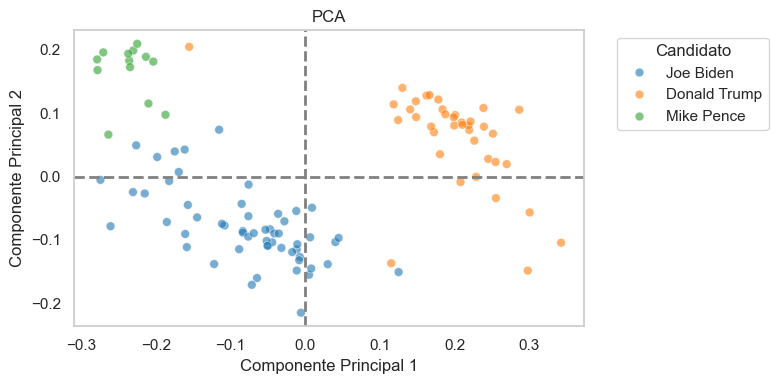

In [29]:
df_pca = pd.DataFrame(X_dev_pca, columns=['PC1', 'PC2'])
df_pca['Candidato'] = y_dev.values

plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Candidato', palette='tab10', s=40, alpha = 0.6)

plt.axhline(0, color='gray', linestyle='--', linewidth=2)
plt.axvline(0, color='gray', linestyle='--', linewidth=2)

plt.title("PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Candidato", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()

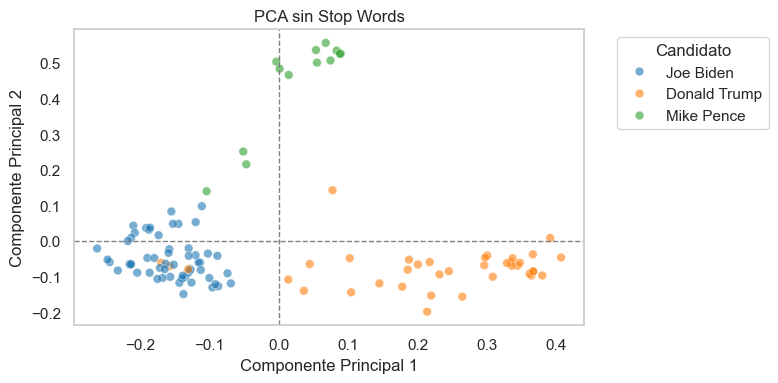

In [30]:
#utiliza el filtrado de stop_words para idioma inglés, el parámetro use_idf=True y ngram_range=(1,2)


# 1. Bag-of-Words 
vectorizer_vf = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 2)
)
X_dev_bow_vf = vectorizer_vf.fit_transform(X_dev)
X_test_bow_vf = vectorizer_vf.transform(X_test)

# 2. TF-IDF
tfidf_vf = TfidfTransformer(use_idf=True)
X_dev_tfidf_vf = tfidf_vf.fit_transform(X_dev_bow_vf)
X_test_tfidf_vf = tfidf_vf.transform(X_test_bow_vf)

# 3. PCA 
X_dev_dense_vf = X_dev_tfidf_vf.toarray()
pca_vf = PCA(n_components=2, random_state=42)
X_dev_pca_vf = pca_vf.fit_transform(X_dev_dense_vf)

# 4. Visualización
sns.set(style="whitegrid")
df_pca_vf = pd.DataFrame(X_dev_pca_vf, columns=["PC1", "PC2"])
df_pca_vf["Candidato"] = y_dev.values  # Asegurar que y_dev está definido

plt.figure(figsize=(8, 4))
ax = sns.scatterplot(
    data=df_pca_vf,
    x="PC1", y="PC2",
    hue="Candidato",
    palette="tab10",
    s=40,
    alpha = 0.6
)

ax.axhline(0, ls="--", c="gray", lw=1)
ax.axvline(0, ls="--", c="gray", lw=1)

plt.title("PCA sin Stop Words")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(False)
plt.legend(title="Candidato", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

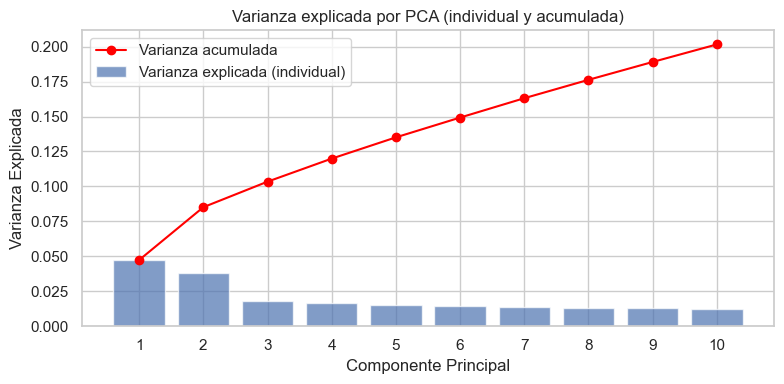

In [116]:
# Haga una visualización que permita entender cómo varía la varianza explicada a medida que se agregan componentes (e.g: hasta 10 componentes).

pca = PCA(n_components=10)
pca.fit(X_dev_dense_vf)

# Varianza explicada por componente
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

plt.figure(figsize=(8, 4))

# Barras: varianza individual
plt.bar(range(1, 11), explained_var, alpha=0.7, label='Varianza explicada (individual)')

# Línea: varianza acumulada
plt.plot(range(1, 11), cum_var, marker='o', color='red', label='Varianza acumulada')

plt.xticks(range(1, 11))
plt.xlabel("Componente Principal")
plt.ylabel("Varianza Explicada")
plt.title("Varianza explicada por PCA (individual y acumulada)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Parte 2: Entrenamiento y Evaluación de Modelos


In [33]:
X_dev_tfidf_vf.toarray()


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
# 1: Entrene el modelo Multinomial Naive Bayes, luego utilícelo para predecir sobre el conjunto de test, y reporte el valor de accuracy y la matriz de confusión. Reporte el valor de precision y recall para cada candidato. 
# Calcular matriz de confusión Sugerencia: utilice el método from_predictions de ConfusionMatrixDisplay para realizar la matriz.

model_nb = MultinomialNB()
model_nb.fit(X_dev_tfidf_vf, y_dev)

y_pred = model_nb.predict(X_test_tfidf_vf)

<Figure size 800x400 with 0 Axes>

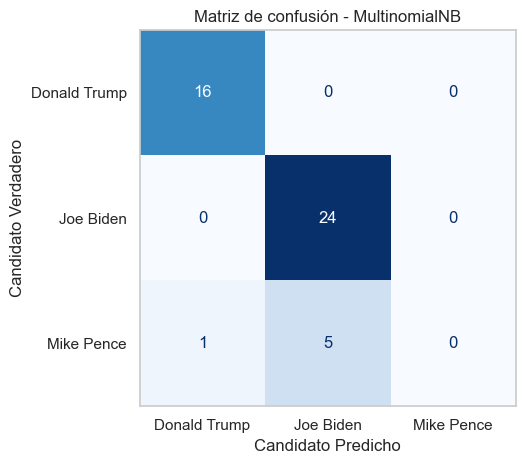

In [42]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=model_nb.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_nb.classes_)
plt.figure(figsize=(8, 4))
disp.plot(cmap='Blues', colorbar=False)
plt.title("Matriz de confusión - MultinomialNB")
plt.ylabel("Candidato Verdadero")
plt.xlabel("Candidato Predicho")
plt.tight_layout()
plt.grid(False)
plt.show()

In [48]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

Donald Trump       0.94      1.00      0.97        16
   Joe Biden       0.83      1.00      0.91        24
  Mike Pence       0.00      0.00      0.00         6

    accuracy                           0.87        46
   macro avg       0.59      0.67      0.63        46
weighted avg       0.76      0.87      0.81        46



In [43]:
# 2: Implemente una búsqueda de hiperparámetros usando GridSearchCV.

# Genere una visualización que permita comparar las métricas (e.g: accuracy) de los distintos modelos entrenados, viendo el valor promedio y variabilidad de las mismas en todos los splits (e.g: en un gráfico de violín).

param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
}

# Búsqueda con validación cruzada
grid_search = GridSearchCV(
    model_nb,
    param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    refit=True
)

# Ejecutar búsqueda en dev
grid_search.fit(X_dev_tfidf_vf, y_dev)

print("Mejor alpha:", grid_search.best_params_)
print("Mejor accuracy promedio (CV):", grid_search.best_score_)


Mejor alpha: {'alpha': 0.01}
Mejor accuracy promedio (CV): 1.0


C:\Users\santi\AppData\Local\Temp\ipykernel_19508\2302297692.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long, x='Alpha', y='Accuracy', inner='box', palette='Blues')


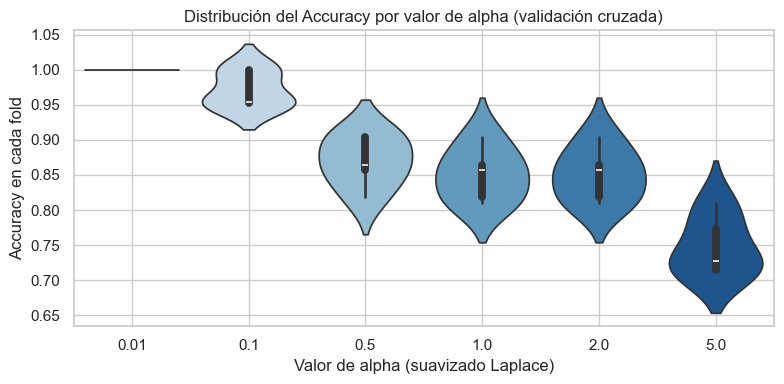

In [44]:
# Extraer resultados de todos los modelos probados
results = pd.DataFrame(grid_search.cv_results_)


plot_data = results[['param_alpha', 'mean_test_score', 'std_test_score']]
plot_data = plot_data.rename(columns={
    'param_alpha': 'Alpha',
    'mean_test_score': 'Accuracy promedio',
    'std_test_score': 'Desvío estándar'
})
split_cols = [col for col in results.columns if col.startswith("split") and col.endswith("_test_score")]
df_splits = results[['param_alpha'] + split_cols]
df_long = df_splits.melt(id_vars='param_alpha', var_name='Split', value_name='Accuracy')
df_long.rename(columns={'param_alpha': 'Alpha'}, inplace=True)

# Gráfico de violín
plt.figure(figsize=(8, 4))
sns.violinplot(data=df_long, x='Alpha', y='Accuracy', inner='box', palette='Blues')

plt.title("Distribución del Accuracy por valor de alpha (validación cruzada)")
plt.xlabel("Valor de alpha (suavizado Laplace)")
plt.ylabel("Accuracy en cada fold")
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

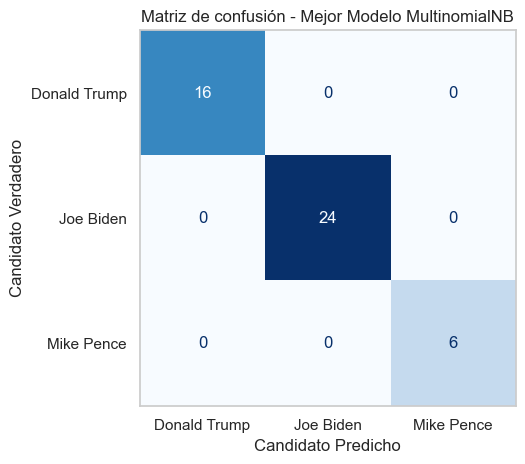

In [ ]:
# 3: Elija el mejor modelo (mejores parámetros) y vuelva a entrenar sobre todo el conjunto de entrenamiento disponible (sin quitar datos para validación). Reporte el valor final de las métricas y la matriz de confusión.

y_pred_best = grid_search.predict(X_test_tfidf_vf)

cm = confusion_matrix(y_test, y_pred_best, labels=grid_search.best_estimator_.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.classes_)
plt.figure(figsize=(8, 4))
disp.plot(cmap='Blues', colorbar=False)
plt.title("Matriz de confusión - Mejor Modelo MultinomialNB")
plt.ylabel("Candidato Verdadero")
plt.xlabel("Candidato Predicho")
plt.tight_layout()
plt.grid(False)
plt.show()

In [47]:
report = classification_report(y_test, y_pred_best)
print(report)

              precision    recall  f1-score   support

Donald Trump       1.00      1.00      1.00        16
   Joe Biden       1.00      1.00      1.00        24
  Mike Pence       1.00      1.00      1.00         6

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



In [48]:
# 4: Evalúe con validación cruzada al menos un modelo más (dentro de scikit-learn) aparte de Multinomial Naive Bayes para clasificar el texto utilizando las mismas features de texto.

modelo_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# Validación cruzada sobre el conjunto de desarrollo
cv_scores_rf = cross_val_score(
    modelo_rf,
    X_dev_tfidf_vf,
    y_dev,
    cv=5,
    scoring='accuracy'
)

In [49]:
print("Accuracies por fold (Random Forest):", cv_scores_rf)
print(f"Accuracy promedio: {cv_scores_rf.mean():.4f}")
print(f"Desvío estándar: {cv_scores_rf.std():.4f}")

Accuracies por fold (Random Forest): [1.         0.86363636 0.85714286 1.         0.76190476]
Accuracy promedio: 0.8965
Desvío estándar: 0.0918


<Figure size 800x400 with 0 Axes>

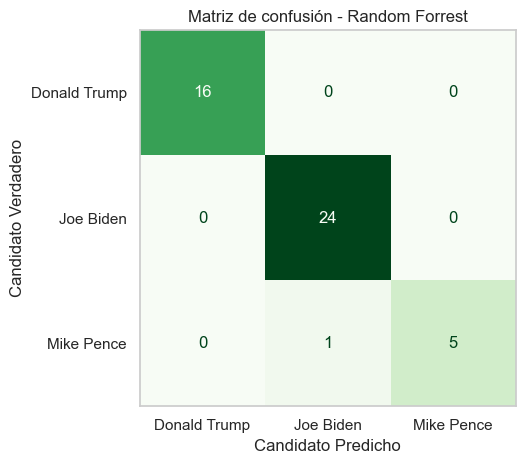

In [51]:
modelo_rf.fit(X_dev_tfidf_vf, y_dev)

# Predecir sobre test
y_pred_rf = modelo_rf.predict(X_test_tfidf_vf)

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=modelo_rf.classes_)

# Visualizar
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=modelo_rf.classes_)

plt.figure(figsize=(8, 4))
disp.plot(cmap='Greens', colorbar=False)
plt.title("Matriz de confusión - Random Forrest")
plt.ylabel("Candidato Verdadero")
plt.xlabel("Candidato Predicho")
plt.tight_layout()
plt.grid(False)
plt.show()

In [52]:
report = classification_report(y_test, y_pred_rf)
print(report)

              precision    recall  f1-score   support

Donald Trump       1.00      1.00      1.00        16
   Joe Biden       0.96      1.00      0.98        24
  Mike Pence       1.00      0.83      0.91         6

    accuracy                           0.98        46
   macro avg       0.99      0.94      0.96        46
weighted avg       0.98      0.98      0.98        46



In [53]:
# 5: Evalúe el problema cambiando al menos un candidato. En particular, observe el (des)balance de datos y los problemas que pueda generar, así como cualquier indicio que pueda ver en el mapeo previo con PCA.

df_2 = df_speeches_top_5[df_speeches_top_5['speaker'].isin(['Joe Biden', 'Kamala Harris', 'Bernie Sanders'])][['speaker', 'speech', 'speech_2' ]]

In [54]:
X2 = df_2['speech']
y2 = df_2['speaker'] 

X_dev2, X_test2, y_dev2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42, stratify=y2)

print(f"Tamaños de los conjuntos: {X_dev2.shape}, {X_test2.shape}")

Tamaños de los conjuntos: (78,), (34,)


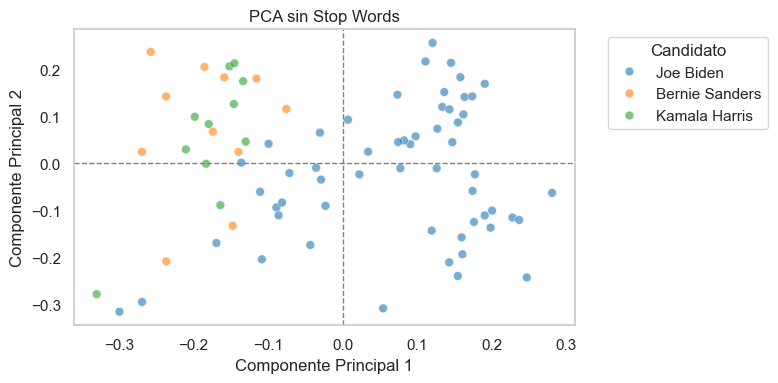

In [55]:
# 1. Bag-of-Words 
vectorizer_vf2 = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 2)
)
X_dev_bow_vf2 = vectorizer_vf2.fit_transform(X_dev2)
X_test_bow_vf2 = vectorizer_vf2.transform(X_test2)

# 2. TF-IDF
tfidf_vf2 = TfidfTransformer(use_idf=True)
X_dev_tfidf_vf2 = tfidf_vf2.fit_transform(X_dev_bow_vf2)
X_test_tfidf_vf2 = tfidf_vf2.transform(X_test_bow_vf2)

# 3. PCA 
X_dev_dense_vf2 = X_dev_tfidf_vf2.toarray()
pca_vf2 = PCA(n_components=2, random_state=42)
X_dev_pca_vf2 = pca_vf2.fit_transform(X_dev_dense_vf2)

# 4. Visualización
sns.set(style="whitegrid")
df_pca_vf2 = pd.DataFrame(X_dev_pca_vf2, columns=["PC1", "PC2"])
df_pca_vf2["Candidato"] = y_dev2.values  # Asegurar que y_dev está definido

plt.figure(figsize=(8, 4))
ax = sns.scatterplot(
    data=df_pca_vf2,
    x="PC1", y="PC2",
    hue="Candidato",
    palette="tab10",
    s=40,
    alpha = 0.6
)

ax.axhline(0, ls="--", c="gray", lw=1)
ax.axvline(0, ls="--", c="gray", lw=1)

plt.title("PCA sin Stop Words")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(False)
plt.legend(title="Candidato", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

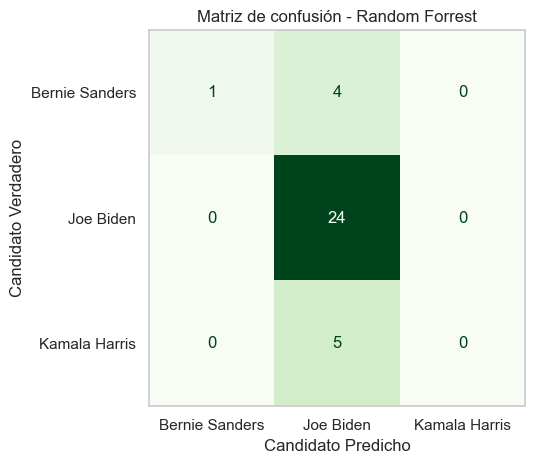

In [56]:
modelo_rf.fit(X_dev_tfidf_vf2, y_dev2)

# Predecir sobre test
y_pred_rf2 = modelo_rf.predict(X_test_tfidf_vf2)

cm_rf2 = confusion_matrix(y_test2, y_pred_rf2, labels=modelo_rf.classes_)

# Visualizar
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf2, display_labels=modelo_rf.classes_)

plt.figure(figsize=(8, 4))
disp.plot(cmap='Greens', colorbar=False)
plt.title("Matriz de confusión - Random Forrest")
plt.ylabel("Candidato Verdadero")
plt.xlabel("Candidato Predicho")
plt.tight_layout()
plt.grid(False)
plt.show()

In [57]:
report = classification_report(y_test2, y_pred_rf2)
print(report)

                precision    recall  f1-score   support

Bernie Sanders       1.00      0.20      0.33         5
     Joe Biden       0.73      1.00      0.84        24
 Kamala Harris       0.00      0.00      0.00         5

      accuracy                           0.74        34
     macro avg       0.58      0.40      0.39        34
  weighted avg       0.66      0.74      0.64        34

